<a href="https://colab.research.google.com/github/dean-daryl/sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import re

import pandas as pd
import kagglehub
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [15]:
# Download dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Dataset downloaded to:", path)

# The CSV file in the downloaded directory is 'IMDB Dataset.csv'
csv_path = os.path.join(path, "IMDB Dataset.csv")


Dataset downloaded to: C:\Users\Djafari\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1


In [16]:
# Load dataset into a pandas DataFrame
df = pd.read_csv(csv_path)

In [17]:
# Preview data
print("Dataset shape:", df.shape)  # Should be (50000, 2)
print(df.head())  # Shows first 5 rows: 'review' and 'sentiment' columns

Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [18]:
print("Dataset Info:")
print(df.info())  # Shows data types, non-null counts

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [19]:
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())  # Should be balanced: ~25K each


Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [20]:
# Checking for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
review       0
sentiment    0
dtype: int64


In [21]:
# Checking for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of duplicate rows:
418


In [22]:
# Handle duplicates
df = df.drop_duplicates()  # Remove duplicates

In [23]:
print(df['sentiment'].value_counts())

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


## Visualizations

C:\Users\Djafari\AppData\Local\Temp\ipykernel_24008\2893965689.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


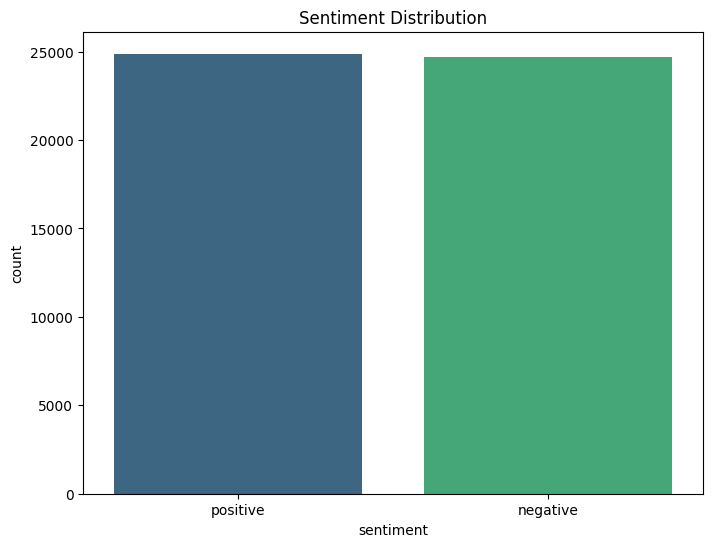

In [24]:
# Sentiment Distribution (bar plot)
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.savefig('sentiment_distribution.png')
plt.show()
plt.close()

For training a sentiment analysis model, having a balanced dataset is key. If the dataset is highly imbalanced, our model might become biased towards the majority class, leading to poor performance on the minority class.

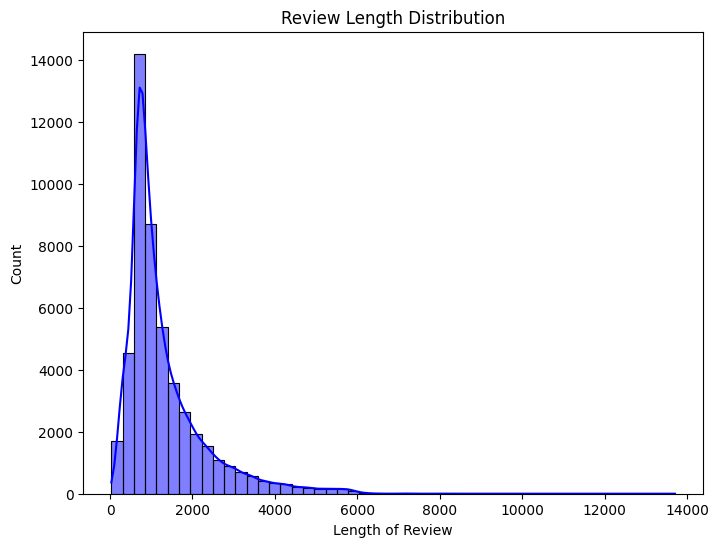

In [25]:
# Review Length Distribution (histogram)
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.title('Review Length Distribution')
plt.xlabel('Length of Review')
plt.savefig('review_length_distribution.png')
plt.show()
plt.close()

C:\Users\Djafari\AppData\Local\Temp\ipykernel_24008\3518153757.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')


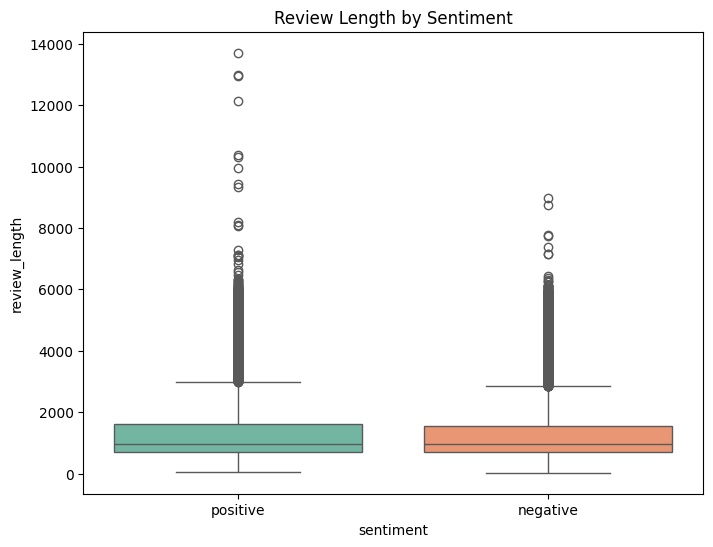

In [26]:
# Boxplot of Review Length by Sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')
plt.title('Review Length by Sentiment')
plt.savefig('review_length_by_sentiment.png')
plt.show()
plt.close()

In [27]:
# Word Clouds for Positive and Negative Reviews
stop_words = set(nltk.corpus.stopwords.words('english'))
positive_text = ' '.join(df[df['sentiment'] == 'positive']['review'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['review'])

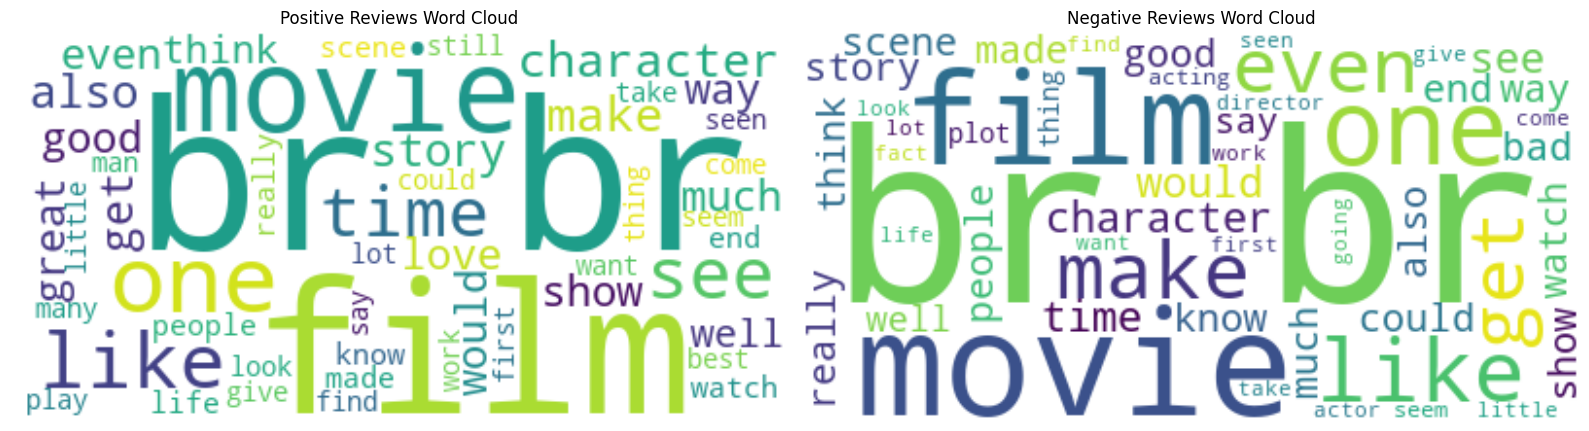

In [28]:
# Positive Word Cloud
wordcloud_pos = WordCloud(stopwords=stop_words, background_color='white', max_words=50).generate(positive_text)

# Negative Word Cloud
wordcloud_neg = WordCloud(stopwords=stop_words, background_color='white', max_words=50).generate(negative_text)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Reviews Word Cloud')

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Reviews Word Cloud')

plt.tight_layout()
plt.savefig('wordclouds_side_by_side.png')
plt.show()
plt.close()

In [29]:
nltk.download('punkt')
nltk.download('punkt_tab', quiet=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Djafari\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [30]:
# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<br />', ' ', text)  # Remove HTML tags (common in IMDB)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars/numbers
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Applying preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [31]:
print(df)

                                                  review sentiment  \
0      One of the other reviewers has mentioned that ...  positive   
1      A wonderful little production. <br /><br />The...  positive   
2      I thought this was a wonderful way to spend ti...  positive   
3      Basically there's a family where a little boy ...  negative   
4      Petter Mattei's "Love in the Time of Money" is...  positive   
...                                                  ...       ...   
49995  I thought this movie did a down right good job...  positive   
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative   
49997  I am a Catholic taught in parochial elementary...  negative   
49998  I'm going to have to disagree with the previou...  negative   
49999  No one expects the Star Trek movies to be high...  negative   

       review_length                                     cleaned_review  
0               1761  one reviewers mentioned watching oz episode yo...  
1          

In [32]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X = df['cleaned_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Binary labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Engineering

In [33]:
# For ML: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [34]:
# For DL: Tokenization and Padding (with basic embeddings)
max_words = 5000
max_len = 200  # Based on EDA, truncate/pad to average length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [35]:
print("Preprocessing completed. Data shapes:", X_train_tfidf.shape, X_train_pad.shape)

Preprocessing completed. Data shapes: (39665, 5000) (39665, 200)


## ML Model: Logistic Regression

In [36]:
# ML Model: Logistic Regression
def train_logistic_regression(X_train, X_test, y_train, y_test, params):
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return model, acc, f1, cm

## DL Model: LSTM

In [37]:
# DL Model: LSTM
def train_lstm(X_train, X_test, y_train, y_test, params):
    model = Sequential([
        Embedding(input_dim=params['max_words'], output_dim=128, input_length=params['max_len']),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_split=0.2, verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return model, acc, f1, cm, history

## Experiment 1: Logistic Regression

In [38]:
# Experiment 1: Logistic Regression (vary C)
lr_experiments = [
    {'C': 0.1, 'max_iter': 1000},
    {'C': 1.0, 'max_iter': 1000},
    {'C': 10.0, 'max_iter': 1000}
]
lr_results = []
for params in lr_experiments:
    _, acc, f1, _ = train_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test, params)
    lr_results.append({'C': params['C'], 'Accuracy': acc, 'F1-Score': f1})
pd.DataFrame(lr_results).to_csv('lr_experiment_results.csv', index=False)

## Experiment 2: LSTM

In [39]:
# Experiment 2: LSTM (vary epochs, batch_size, optimizer)
lstm_experiments = [
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 5, 'batch_size': 64, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'rmsprop'}
]
lstm_results = []
for params in lstm_experiments:
    _, acc, f1, _, _ = train_lstm(X_train_pad, X_test_pad, y_train, y_test, params)
    lstm_results.append({'Epochs': params['epochs'], 'Batch Size': params['batch_size'],
                         'Optimizer': params['optimizer'], 'Accuracy': acc, 'F1-Score': f1})
pd.DataFrame(lstm_results).to_csv('lstm_experiment_results.csv', index=False)

c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 65s 64ms/step - accuracy: 0.7705 - loss: 0.4692 - val_accuracy: 0.8704 - val_loss: 0.3090
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.8951 - loss: 0.2652 - val_accuracy: 0.8810 - val_loss: 0.2928
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.9259 - loss: 0.1974 - val_accuracy: 0.8776 - val_loss: 0.3162
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Epoch 1/5


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 56s 107ms/step - accuracy: 0.7566 - loss: 0.4809 - val_accuracy: 0.8713 - val_loss: 0.3153
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - accuracy: 0.9042 - loss: 0.2497 - val_accuracy: 0.8746 - val_loss: 0.3047
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.9235 - loss: 0.2020 - val_accuracy: 0.8755 - val_loss: 0.3216
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - accuracy: 0.9394 - loss: 0.1645 - val_accuracy: 0.8700 - val_loss: 0.3389
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - accuracy: 0.9525 - loss: 0.1310 - val_accuracy: 0.8592 - val_loss: 0.3709
310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Epoch 1/3


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 77s 75ms/step - accuracy: 0.7762 - loss: 0.4584 - val_accuracy: 0.8786 - val_loss: 0.3018
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - accuracy: 0.8979 - loss: 0.2671 - val_accuracy: 0.8837 - val_loss: 0.2826
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 76s 76ms/step - accuracy: 0.9107 - loss: 0.2336 - val_accuracy: 0.8821 - val_loss: 0.2832
310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [40]:
print("Experiments completed. Results in CSVs.")

Experiments completed. Results in CSVs.


##Final Evaluations

In [41]:
# Assume best params from experiments (e.g., C=1.0 for LR, first LSTM config)
# Final LR Evaluation
lr_params = {'C': 1.0, 'max_iter': 1000}
_, lr_acc, lr_f1, lr_cm = train_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test, lr_params)

In [42]:
# Final LSTM Evaluation
lstm_params = {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'}
_, lstm_acc, lstm_f1, lstm_cm, history = train_lstm(X_train_pad, X_test_pad, y_train, y_test, lstm_params)

Epoch 1/3


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 78s 77ms/step - accuracy: 0.7915 - loss: 0.4332 - val_accuracy: 0.8785 - val_loss: 0.2918
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.9096 - loss: 0.2361 - val_accuracy: 0.8771 - val_loss: 0.2952
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.9209 - loss: 0.2114 - val_accuracy: 0.8766 - val_loss: 0.3182
310/310 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


In [43]:
# Plot Confusion Matrices
def plot_confusion_matrix(cm, title, filename):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(filename)
    plt.show()
    plt.close()

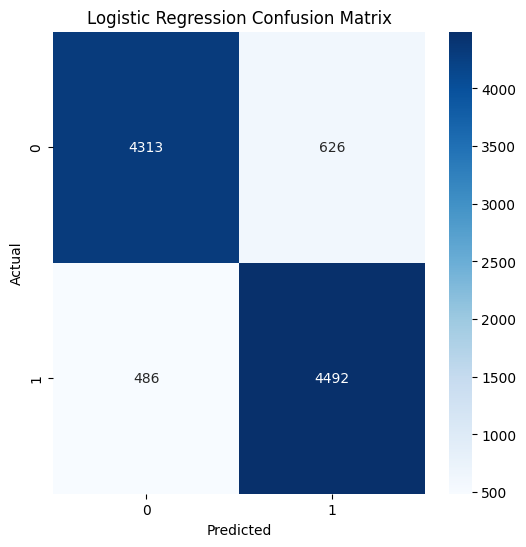

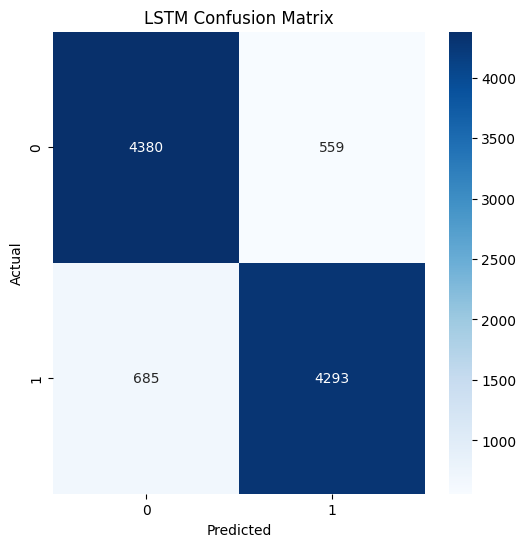

In [44]:
plot_confusion_matrix(lr_cm, 'Logistic Regression Confusion Matrix', 'lr_cm.png')
plot_confusion_matrix(lstm_cm, 'LSTM Confusion Matrix', 'lstm_cm.png')

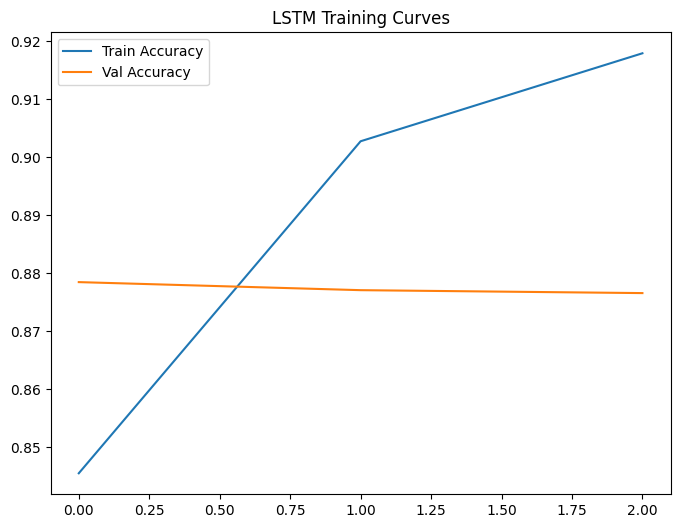

In [45]:
# Plot LSTM Training History
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Training Curves')
plt.legend()
plt.savefig('lstm_training_curves.png')
plt.show()
plt.close()

In [46]:
# Print Metrics
print("LR: Acc=", lr_acc, "F1=", lr_f1)
print("LSTM: Acc=", lstm_acc, "F1=", lstm_f1)

LR: Acc= 0.8878693153171322 F1= 0.8898573692551506
LSTM: Acc= 0.8745588383583746 F1= 0.8734486266531027


# GRU Model: Architecture, Hyperparameters, and Justification
Architecture Details

Embedding Layer (128 dims): Converts integer-encoded words into dense vectors, allowing the model to learn semantic relationships.

GRU Layer (64 units): Efficiently processes sequential data and retains long-term dependencies, outperforming standard RNNs for most text tasks.

Dropout Layer (0.5): Reduces overfitting by randomly deactivating half the neurons during training.

Dense Layer (1 unit, sigmoid): Outputs probabilities for binary classification.

# Hyperparameters

max_words: Sets vocabulary size to ensure efficient training and avoid noise from rare words.

max_len: Limits input sequence length for computational manageability and padding consistency.

epochs (3 or 5): Number of training iterations; lower values help avoid overfitting, higher for more learning capacity.

batch_size (32 or 64): Controls update frequency; smaller batch sizes (32) tend to increase generalization and training stability.

optimizer (Adam): Chosen for adaptive learning rates and faster convergence.

loss (binary crossentropy): Matches binary output and probability-based prediction.

# Justifications

Embedding and GRU structure is well-suited for sequence modeling in classification problems.

Dropout is critical for neural network regularization.

Hyperparameters like epochs and batch size are tuned experimentally to optimize validation accuracy and F1-score while preventing overfitting.

Adam optimizer and binary crossentropy cost are industry standards for efficient text classification.

In [47]:
from sklearn.metrics import precision_score, recall_score, log_loss

# DL Model: GRU (updated with all metrics)
def train_gru(X_train, X_test, y_train, y_test, params):
    model = Sequential([
        Embedding(input_dim=params['max_words'], output_dim=128, input_length=params['max_len']),
        tf.keras.layers.GRU(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_split=0.2, 
        verbose=1
    )
    
    # Predictions and metrics
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    ce_loss = log_loss(y_test, y_pred_prob)  # Cross-entropy loss
    cm = confusion_matrix(y_test, y_pred)
    
    return model, acc, f1, precision, recall, ce_loss, cm, history

In [48]:
# Experiment 3: GRU (hyperparameter variations)
gru_experiments = [
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 5, 'batch_size': 64, 'optimizer': 'adam'}
]

gru_results = []
for params in gru_experiments:
    _, acc, f1, precision, recall, ce_loss, _, _ = train_gru(X_train_pad, X_test_pad, y_train, y_test, params)
    gru_results.append({
        'Epochs': params['epochs'],
        'Batch Size': params['batch_size'],
        'Optimizer': params['optimizer'],
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Cross-Entropy': ce_loss
    })

pd.DataFrame(gru_results).to_csv('gru_experiment_results.csv', index=False)



Epoch 1/3


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 72s 70ms/step - accuracy: 0.7514 - loss: 0.4825 - val_accuracy: 0.8795 - val_loss: 0.2894
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 74s 75ms/step - accuracy: 0.9080 - loss: 0.2344 - val_accuracy: 0.8823 - val_loss: 0.2875
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.9337 - loss: 0.1803 - val_accuracy: 0.8723 - val_loss: 0.3086
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 1/5


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.7430 - loss: 0.4906 - val_accuracy: 0.8679 - val_loss: 0.3143
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.9036 - loss: 0.2518 - val_accuracy: 0.8773 - val_loss: 0.2938
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 46s 94ms/step - accuracy: 0.9297 - loss: 0.1923 - val_accuracy: 0.8766 - val_loss: 0.3008
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.9427 - loss: 0.1588 - val_accuracy: 0.8704 - val_loss: 0.3386
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.9566 - loss: 0.1252 - val_accuracy: 0.8670 - val_loss: 0.4236
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


In [49]:
# Final GRU Evaluation (choose best params)
gru_params = {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'}
_, gru_acc, gru_f1, gru_precision, gru_recall, gru_ce, gru_cm, gru_history = train_gru(
    X_train_pad, X_test_pad, y_train, y_test, gru_params
)

Epoch 1/3


c:\Users\Djafari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 70s 68ms/step - accuracy: 0.7243 - loss: 0.5141 - val_accuracy: 0.8750 - val_loss: 0.3007
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 66s 67ms/step - accuracy: 0.9016 - loss: 0.2509 - val_accuracy: 0.8789 - val_loss: 0.2898
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 66s 66ms/step - accuracy: 0.9317 - loss: 0.1860 - val_accuracy: 0.8810 - val_loss: 0.2932
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


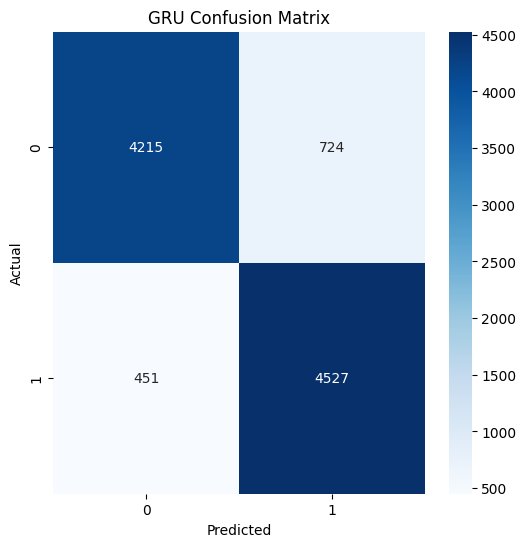

In [50]:
# Plot Confusion Matrix
plot_confusion_matrix(gru_cm, 'GRU Confusion Matrix', 'gru_cm.png')

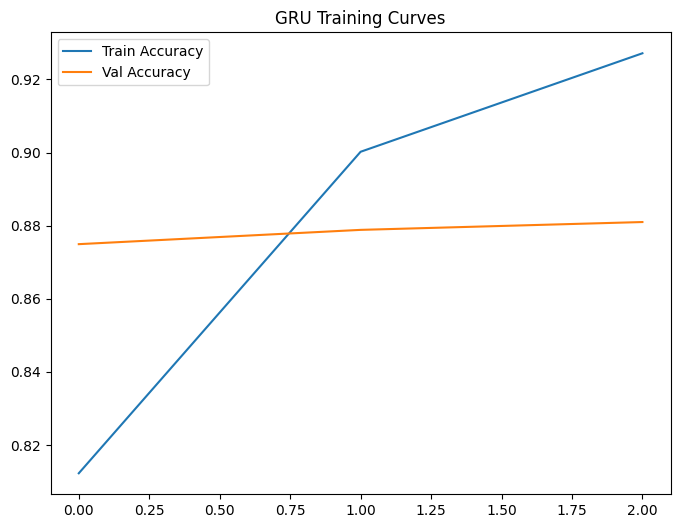

In [53]:
# Plot Training History
plt.figure(figsize=(8, 6))
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Val Accuracy')
plt.title('GRU Training Curves')
plt.legend()
plt.savefig('gru_training_curves.png')
plt.show()
plt.close()

In [52]:
# Print Metrics
print(f"GRU Metrics:\nAccuracy: {gru_acc}\nPrecision: {gru_precision}\nRecall: {gru_recall}\nF1-Score: {gru_f1}\nCross-Entropy: {gru_ce}")

GRU Metrics:
Accuracy: 0.8815165876777251
Precision: 0.8621215006665397
Recall: 0.909401366010446
F1-Score: 0.8851305112914264
Cross-Entropy: 0.29649488421380144
